## Train a MNIST classifier

In this tutorial, you will learn how to use Pax to train a simple CNN to classifier hand-written digits from the MNIST dataset.

The main steps of the tutorial:

1. Load MNIST dataset with ``tensorflow_datasets``.
2. Create a simple ``Sequential`` module.
3. Implement the MSE loss function and ``update_fn`` function.
5. Create data loader and train model.

### MNIST dataset

First, we will load MNIST dataset using ``tensorflow_datasets`` library and show a few examples.

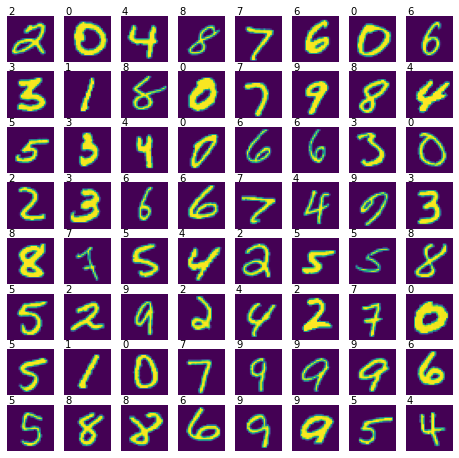

In [1]:
import math
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

mnist_data = tfds.load('mnist')

def plot_image_grid(images, labels):
    N = len(images)
    size = int(math.sqrt(N))
    plt.figure(figsize=(size, size))
    for i in range(N):
        plt.subplot(size, size, i+1)
        plt.imshow(images[i])
        plt.text(0, -1, labels[i])
        plt.axis('off')
    plt.show()

batch = next(mnist_data['test'].take(64).batch(64).as_numpy_iterator())
plot_image_grid(batch['image'], batch['label'])

### Convolution Neural Net

Now, we will use ``Pax`` to implement a simple CNN using the ``pax.nn.Sequential``, ``pax.nn.Conv2D`` modules.

**Note**:

* ``pax.nn.Sequential`` allows us to define a module as a sequence of computational steps.
* ``pax.nn.Conv2D`` is a Pax's convolution module for 2d images.
* ``net.summary()`` return a summary of all submodules in ``net`` in a tree-lile format.

In [2]:
import pax
import jax
import jax.numpy as jnp

pax.seed_rng_key(42)

net = pax.nn.Sequential(
    pax.nn.Conv2D(1, 32, 5, stride=1, padding='VALID'),
    jax.nn.relu,
    pax.nn.Conv2D(32, 64, 5, stride=2, padding='VALID'),
    jax.nn.relu,
    pax.nn.Conv2D(64, 128, 3, stride=2, padding='VALID'),
    jax.nn.relu,
    pax.nn.Conv2D(128, 10, 4, stride=1, padding='VALID'),
    lambda x: x.reshape((x.shape[0], -1))
)

print(net.summary())

Sequential
├── Conv2D[in_features=1, out_features=32, with_bias=True]
├── x => relu(x)
├── Conv2D[in_features=32, out_features=64, with_bias=True]
├── x => relu(x)
├── Conv2D[in_features=64, out_features=128, with_bias=True]
├── x => relu(x)
├── Conv2D[in_features=128, out_features=10, with_bias=True]
└── x => <function <lambda> at 0x7fcba0506f28>(x)


We plot the predictions of the untrained model as a simple sanity check.

**Note**: we are normalizing MNIST images to the value range ``[-1, 1]`` as this is the preferred range of neural nets.

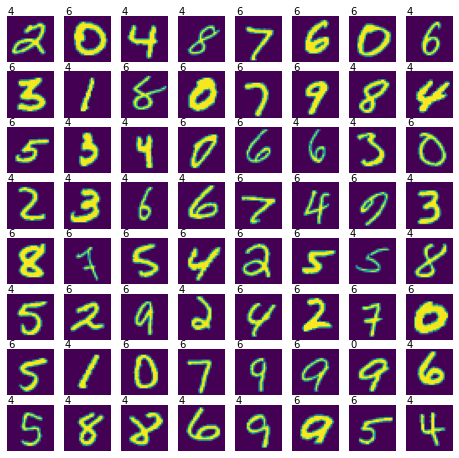

In [3]:
images = batch['image'].astype(jnp.float32)  / 255. * 2. - 1.
logits = net(images)
labels = jnp.argmax(logits, axis=-1)

plot_image_grid(images, labels)

### Loss function and update function

We will use a *cross entropy* loss function and follow Pax's standard loss function signature: 

    loss_fn:    params, model, inputs -> LossFnOutput

In [4]:
def loss_fn(params: pax.Module, model: pax.Module, inputs) -> pax.utils.LossFnOutput:
    model = model.update(params)
    images, labels = inputs['image'], inputs['label']
    images = images.astype(jnp.float32) / 255. * 2. - 1. # normalize to [-1, 1]
    logits = model(images)
    
    # cross entropy loss
    log_prs = jax.nn.log_softmax(logits)
    log_prs = jax.nn.one_hot(labels, num_classes=logits.shape[-1]) * log_prs
    log_pr = jnp.sum(log_prs, axis=-1)
    loss = -jnp.mean(log_pr) # negative log likelihood
    return loss, (loss, model)

Next, we will implement an ``update`` function. It uses our model, optimizer and data. It returns the updated model and updated optimizer. We use ``jax.jit`` to the ``update`` function fast.

**Note**: Pax provides the same functionality in ``jax.utils.build_update_fn``.

In [5]:
# update_fn = jax.utils.build_update_fn(loss_fn)
def update_fn(model: pax.Module, optimizer: pax.Optimizer, inputs):
    grads, (loss, model) = jax.grad(loss_fn, has_aux=True)(model.parameters(), model, inputs)
    model = optimizer.step(grads, model)
    return loss, model, optimizer

fast_update_fn = jax.jit(update_fn)

We use the ``adam`` optimizer from ``optax`` library. Pax allows us to convert any optax optimizer to a ``pax.Module``.

In [6]:
import optax

learning_rate = 1e-4
optax_adam = optax.adam(learning_rate)
optimizer = pax.optim.from_optax(optax_adam)(net.parameters())

### Tensorflow dataloader and training

Now, define a tensorflow dataloader:

In [7]:
batch_size = 32
num_training_steps = 10000

dataloader = (
    mnist_data['train']
    .cache()
    .repeat()
    .shuffle(100 * batch_size)
    .batch(batch_size)
    .take(num_training_steps)
    .prefetch(1)
    .enumerate(1)
    .as_numpy_iterator()
)

Finally, let's train our model

[step 1000]  loss 0.388
[step 2000]  loss 0.126
[step 3000]  loss 0.086
[step 4000]  loss 0.074
[step 5000]  loss 0.058
[step 6000]  loss 0.054
[step 7000]  loss 0.045
[step 8000]  loss 0.043
[step 9000]  loss 0.037
[step 10000]  loss 0.035


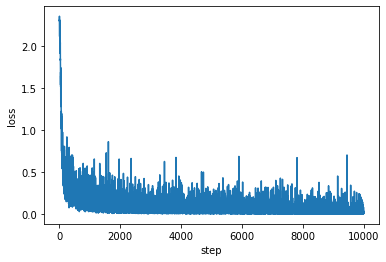

In [8]:
total_losses = 0.0
losses = []
for step, inputs in dataloader:
    loss, net, optimizer = fast_update_fn(net, optimizer, inputs)
    total_losses = loss + total_losses
    losses.append(loss)
    if step % 1000 == 0:
        loss = total_losses / 1000
        total_losses = 0.
        print(f'[step {step}]  loss {loss:.3f}')
        
plt.plot(losses)
plt.xlabel('step')
plt.ylabel('loss')
plt.show()

Let's plot the predictions of our trained model as a simple sanity check.

**Note**: we are doing prediction on the ``test`` set.

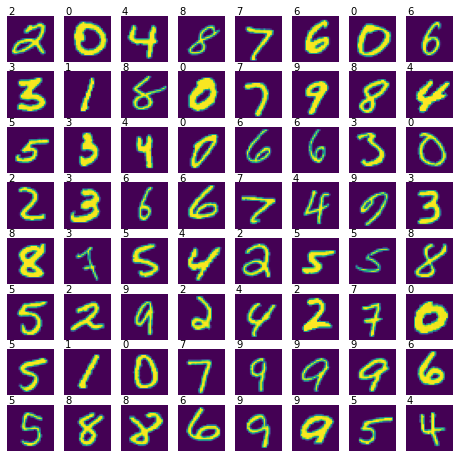

In [9]:
batch = next(mnist_data['test'].take(64).batch(64).as_numpy_iterator())
images = batch['image'].astype(jnp.float32)  / 255. * 2. - 1.  # [-1, 1]
logits = net(images)
labels = jnp.argmax(logits, axis=-1)

plot_image_grid(images, labels)